In [19]:
import json
import os
from collections import defaultdict
import random

import numpy as np
import scipy as sp
from allennlp.commands.elmo import ElmoEmbedder
from sklearn.manifold import MDS
%matplotlib inline
import matplotlib.pyplot as plt

In [20]:
random.seed(271)
np.random.seed(271)

DATASET_FOLDER = 'NeuralDialog-ZSDG/data/stanford'
ELMO = ElmoEmbedder()

01/15/2019 18:42:56 - INFO - allennlp.commands.elmo -   Initializing ELMo.


In [5]:
def load_smd(in_data_folder):
    result = {}
    for dataset in ['train', 'dev', 'test']:
        with open(os.path.join(in_data_folder, 'kvret_{}_public.json'.format(dataset))) as dataset_in:
            result[dataset] = json.load(dataset_in)
    return result

In [6]:
def build_vocabulary(in_utterances):
    result = defaultdict(lambda: 0)

    for utterance in in_utterances:
        for word in utterance.split():
            result[word] += 1
    return result

In [7]:
def jaccard(a, b):
    return len(set(a).intersection(b)) / float(len(set(a).union(b)))

In [8]:
def embed_utterance(utterance, embedder=ELMO):
    utterance_tokenized = utterance.split()
    embedding = embedder.embed_sentence(utterance_tokenized)
    return embedding[-1][-1]

In [22]:
def embed_dataset(in_utterances, embedder=ELMO, sample_size=None):
    if sample_size is None:
        sample_size = len(in_utterances)
    utterances_sample = np.random.choice(in_utterances, size=sample_size, replace=False).tolist()
    result = []
    for utterance in utterances_sample:
        result.append(embed_utterance(utterance))
    return result

In [26]:
def compute_dataset_stats(in_embeddings):
    cluster_centroid = np.mean(in_embeddings, axis=0)
    distances = []
    for i in range(len(in_embeddings)):
        for j in range(i + 1, len(in_embeddings)):
            distances.append(sp.spatial.distance.cosine(in_embeddings[i], in_embeddings[j]))
    return {'centroid': cluster_centroid,
            'distance_max': np.max(distances),
            'distance_min': np.min(distances),
            'distance_avg': np.mean(distances)}

In [55]:
def compute_cross_dataset_stats(dataset_a, dataset_b):
    distances = []
    for emb_a in dataset_a:
        for emb_b in dataset_b:
            distances.append(sp.spatial.distance.cosine(emb_a, emb_b))
    return {'distance_max': np.max(distances),
            'distance_min': np.min(distances),
            'distance_avg': np.mean(distances)}

In [11]:
smd = load_smd(DATASET_FOLDER)

Common dataset statistics
==

In [12]:
smd_train = list(filter(lambda x: len(x['dialogue']), smd['train']))
dialog_lengths = [len(dialog['dialogue']) for dialog in smd_train]

print('Dialog length: {} (min), {} (max), {:.2f} (avg)'.format(np.min(dialog_lengths),
                                                               np.max(dialog_lengths),
                                                               np.mean(dialog_lengths)))

Dialog length: 1 (min), 12 (max), 5.25 (avg)


Navigate domain
==

In [28]:
smd_train_navigate = list(filter(lambda x: x['scenario']['task']['intent'] == 'navigate', smd['train']))

smd_navigate_utterances = []
for dialog in smd_train_navigate:
    if not len(turn):
        continue
    for turn in dialog['dialogue']:
        smd_navigate_utterances.append(turn['data']['utterance'])

navigate_vocab = build_vocabulary(smd_navigate_utterances)
navigate_elmo_embeddings = embed_dataset(smd_navigate_utterances, sample_size=500)

In [27]:
navigate_dialog_lengths = [len(dialog['dialogue']) for dialog in smd_train_navigate]
print('Dialog length: {} (min), {} (max), {:.2f} (avg)'.format(np.min(navigate_dialog_lengths),
                                                               np.max(navigate_dialog_lengths),
                                                               np.mean(navigate_dialog_lengths)))
print('Vocabulary size: {}'.format(len(navigate_vocab)))
print('Dialogs number: {}'.format(len(smd_train_navigate)))
print('Utterances number: {}'.format(len(smd_navigate_utterances)))

navigate_elmo_stats = compute_dataset_stats(navigate_elmo_embeddings)
print('Intra-cluster distance: {:.2f} (min), {:.2f} (max), {:.2f} (avg)'.format(navigate_elmo_stats['distance_min'],
                                                                                navigate_elmo_stats['distance_max'],
                                                                                navigate_elmo_stats['distance_avg']))
print('Top vocabulary words:')
for word, freq in sorted(navigate_vocab.items(), reverse=True, key=lambda x: x[1])[:10]:
    print('{}:\t{}'.format(word, freq))

Dialog length: 4 (min), 12 (max), 6.56 (avg)
Vocabulary size: 1818
Dialogs number: 800
Utterances number: 5248
Intra-cluster distance: 0.00 (min), 0.97 (max), 0.56 (avg)
Top vocabulary words:
the:	2125
is:	1851
to:	1347
you:	877
a:	756
miles:	743
route:	729
and:	681
me:	680
I:	642


Weather domain
==

In [43]:
smd_train_weather = list(filter(lambda x: x['scenario']['task']['intent'] == 'weather', smd['train']))

smd_weather_utterances = []
for dialog in smd_train_weather:
    for turn in dialog['dialogue']:
        if not len(turn):
            continue
        smd_weather_utterances.append(turn['data']['utterance'])

weather_vocab = build_vocabulary(smd_weather_utterances)
weather_elmo_embeddings = embed_dataset(smd_weather_utterances, sample_size=500)

In [44]:
weather_dialog_lengths = [len(dialog['dialogue']) for dialog in smd_train_weather]

print('Dialog length: {} (min), {} (max), {:.2f} (avg)'.format(np.min(weather_dialog_lengths),
                                                               np.max(weather_dialog_lengths),
                                                               np.mean(weather_dialog_lengths)))
print('Vocabulary size: {}'.format(len(weather_vocab)))
print('Dialogs number: {}'.format(len(smd_train_weather)))
print('Utterances number: {}'.format(len(smd_weather_utterances)))

weather_elmo_stats = compute_dataset_stats(weather_elmo_embeddings)
print('Intra-cluster distance: {:.2f} (min), {:.2f} (max), {:.2f} (avg)'.format(weather_elmo_stats['distance_min'],
                                                                                weather_elmo_stats['distance_max'],
                                                                                weather_elmo_stats['distance_avg']))

print('Top vocabulary words:')
for word, freq in sorted(weather_vocab.items(), reverse=True, key=lambda x: x[1])[:10]:
    print('{}:\t{}'.format(word, freq))

Dialog length: 1 (min), 8 (max), 5.41 (avg)
Vocabulary size: 1174
Dialogs number: 797
Utterances number: 4314
Intra-cluster distance: 0.00 (min), 0.96 (max), 0.57 (avg)
Top vocabulary words:
in:	1305
the:	1238
be:	1046
you:	753
will:	723
is:	631
it:	606
to:	599
on:	598
weather:	566


Schedule domain
==

In [45]:
smd_train_schedule = list(filter(lambda x: x['scenario']['task']['intent'] == 'schedule', smd['train']))

smd_schedule_utterances = []
for dialog in smd_train_schedule:
    for turn in dialog['dialogue']:
        if not len(turn):
            continue
        smd_schedule_utterances.append(turn['data']['utterance'])

schedule_vocab = build_vocabulary(smd_schedule_utterances)
schedule_elmo_embeddings = embed_dataset(smd_schedule_utterances, sample_size=500)

In [48]:
schedule_dialog_lengths = [len(dialog['dialogue']) for dialog in smd_train_schedule]

print('Dialog length: {} (min), {} (max), {:.2f} (avg)'.format(np.min(schedule_dialog_lengths),
                                                               np.max(schedule_dialog_lengths),
                                                               np.mean(schedule_dialog_lengths)))
print('Vocabulary size: {}'.format(len(schedule_vocab)))
print('Dialogs number: {}'.format(len(smd_train_schedule)))
print('Utterances number: {}'.format(len(smd_schedule_utterances)))

schedule_elmo_stats = compute_dataset_stats(schedule_elmo_embeddings)
print('Intra-cluster distance: {:.2f} (min), {:.2f} (max), {:.2f} (avg)'.format(schedule_elmo_stats['distance_min'],
                                                                                schedule_elmo_stats['distance_max'],
                                                                                schedule_elmo_stats['distance_avg']))

print('Top vocabulary words:')
for word, freq in sorted(schedule_vocab.items(), reverse=True, key=lambda x: x[1])[:10]:
    print('{}:\t{}'.format(word, freq))

Dialog length: 0 (min), 10 (max), 3.83 (avg)
Vocabulary size: 1233
Dialogs number: 828
Utterances number: 3170
Intra-cluster distance: 0.00 (min), 0.93 (max), 0.57 (avg)
Top vocabulary words:
the:	1250
at:	1074
is:	873
on:	865
with:	835
for:	685
a:	624
and:	511
my:	502
to:	478


Cross-domain vocabulary overlap
==

In [49]:
print('Navigate ^ weather: {:.3f}'.format(jaccard(navigate_vocab.keys(), weather_vocab.keys())))
print('Navigate ^ schedule: {:.3f}'.format(jaccard(navigate_vocab.keys(), schedule_vocab.keys())))
print('Schedule ^ weather: {:.3f}'.format(jaccard(schedule_vocab.keys(), weather_vocab.keys())))

Navigate ^ weather: 0.146
Navigate ^ schedule: 0.159
Schedule ^ weather: 0.190


Cross-dataset stats
==

In [57]:
navigate_weather_stats = compute_cross_dataset_stats(navigate_elmo_embeddings, weather_elmo_embeddings)
navigate_schedule_stats = compute_cross_dataset_stats(navigate_elmo_embeddings, schedule_elmo_embeddings)
schedule_weather_stats = compute_cross_dataset_stats(schedule_elmo_embeddings, weather_elmo_embeddings)

print('Navigate ^ weather: {:.3f} (min), {:.3f} (max), {:.3f} (avg)'.format(navigate_weather_stats['distance_min'],
                                                                            navigate_weather_stats['distance_max'],
                                                                            navigate_weather_stats['distance_avg']))
print('Navigate ^ schedule: {:.3f} (min), {:.3f} (max), {:.3f} (avg)'.format(navigate_schedule_stats['distance_min'],
                                                                             navigate_schedule_stats['distance_max'],
                                                                             navigate_schedule_stats['distance_avg']))
print('Schedule ^ weather: {:.3f} (min), {:.3f} (max), {:.3f} (avg)'.format(schedule_weather_stats['distance_min'],
                                                                            schedule_weather_stats['distance_max'],
                                                                            schedule_weather_stats['distance_avg']))

Navigate ^ weather: 0.000 (min), 0.983 (max), 0.589 (avg)
Navigate ^ schedule: 0.000 (min), 0.950 (max), 0.587 (avg)
Schedule ^ weather: 0.000 (min), 0.969 (max), 0.593 (avg)


In [69]:
mds = MDS(n_components=2)
elmo_transformed = mds.fit_transform(np.concatenate([navigate_elmo_embeddings, weather_elmo_embeddings, schedule_elmo_embeddings]).astype(np.float64))

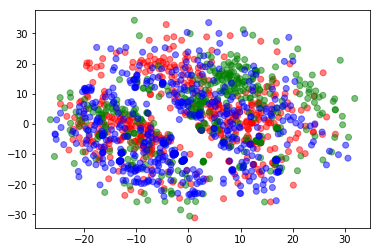

In [71]:
plt.scatter(elmo_transformed[:,0],
            elmo_transformed[:,1],
            alpha=0.5,
            c=['red'] * len(navigate_elmo_embeddings) + ['green'] * len(weather_elmo_embeddings) + ['blue'] * len(schedule_elmo_embeddings))
plt.show()